In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
from PIL import Image
import numpy as np
import time
from typing import Tuple # For type hinting (best practice)
import sys
sys.path.append('../utils')

In [3]:
from radiomics_helper import *

In [4]:
# --- Configuration ---
# You need to adjust these paths to match where your 'images' and 'masks' folders are located.
ROOT_DIR = "../data/mass_data/AIIMS_Delhi_Mass_Data/" 
IMAGE_DIR = os.path.join(ROOT_DIR, "images/")
MASK_DIR = os.path.join(ROOT_DIR, "labels/")

# Hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 4 # Reduced for segmentation due to high memory consumption
IMAGE_SIZE = (256, 256) # Standardize all images to this size (must be powers of 2 for U-Net)
NUM_EPOCHS = 20

In [5]:
DEVICE

'cuda'

In [6]:
class BreastSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        """
        Initialization: Loads all file paths once to speed up access later.

        Args:
            image_dir (str): Path to the folder containing input images.
            mask_dir (str): Path to the folder containing ground truth masks.
            transform (callable, optional): Optional transforms for data augmentation.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        # Literal: Lists all files in the image directory and sorts them.
        self.images = sorted(os.listdir(image_dir))
        
        # Conceptual: We assume your mask files have the same base name as your image files 
        # (e.g., 'patient001.png' and 'patient001_mask.png'). This sorting is crucial 
        # to ensure that image[i] always corresponds to mask[i].
        self.masks = sorted(os.listdir(mask_dir))
        
        # If no custom transform is provided, we define a default one.
        if transform is None:
            self.transform = transforms.Compose([
                # Resize all images/masks to the required size.
                transforms.Resize(IMAGE_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
                # Convert the PIL image to a PyTorch Tensor (and normalizes to [0, 1]).
                transforms.ToTensor(),
            ])
        else:
            self.transform = transform
            
        # Expert Check: Ensure the number of images and masks match.
        if len(self.images) != len(self.masks):
            raise ValueError(f"Mismatched files: Found {len(self.images)} images and {len(self.masks)} masks.")

    def __len__(self) -> int:
        """Returns the total number of samples in the dataset."""
        return len(self.images)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        The core function: loads, preprocesses, and returns a single sample.
        """
        # 1. Path Construction
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        # 2. Image Loading and Mode Conversion
        # Ultrasound is typically grayscale. We force 'L' (Luminance) mode for the image.
        image = read_as_grayscale(img_path)
        image = torch.from_numpy(image)[None, ...]
        # Masks are binary (0/1 or 0/255). We force 'L' mode and ensure it's not converted to RGB.
        mask = read_as_grayscale(mask_path)
        mask = torch.from_numpy(mask)[None, ...]

        # 3. Applying Transformation
        image = self.transform(image)
        mask = self.transform(mask)

        # 4. Critical Type and Range Conversion
        
        # Conceptual: Image data should be Float32 for model computation. 
        # The ToTensor() transform already handles this (0.0 to 1.0 range).
        
        # Conceptual: Mask data must also be Float32 in the range [0.0, 1.0] 
        # because the loss function (BCEWithLogitsLoss) expects floating-point ground truth.
        # If your masks were loaded as 0/255 integers, ToTensor() automatically converts them 
        # to 0.0/1.0 floats.

        # Ensure the mask remains binary after resizing/transformations (optional but safe)
        mask[mask > 0.5] = 1.0
        mask[mask <= 0.5] = 0.0
        
        return image, mask

In [7]:
# --- Data Loader Initialization ---
# 1. Create the Dataset instance
train_dataset = BreastSegmentationDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    # Here you would typically add data augmentation transforms
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        #transforms.ToTensor(),
        # Example Augmentation: transforms.RandomRotation(10),
    ])
)

# 2. Create the DataLoader
# Conceptual: The DataLoader is an iterable that batches and shuffles your data. 
# 'num_workers' uses separate processes to load data concurrently, preventing the CPU from 
# bottlenecking the GPU. Set this to a small number (e.g., 2 or 4) based on your CPU cores.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0, 
    pin_memory=True # Transfers data from CPU to pinned memory, speeding up GPU transfer
)

print(f"Total number of samples: {len(train_dataset)}")
# Sanity check the first batch
data_sample, target_sample = next(iter(train_loader))
print(f"Batch Image Shape (B, C, H, W): {data_sample.shape}") 
print(f"Batch Mask Shape (B, C, H, W): {target_sample.shape}")

Total number of samples: 310
Batch Image Shape (B, C, H, W): torch.Size([4, 1, 256, 256])
Batch Mask Shape (B, C, H, W): torch.Size([4, 1, 256, 256])


In [8]:
# Reusing the DoubleConv module for clarity and modularity
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        # PyTorch Sequential container groups operations into a single step
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            # Bias is often set to False when BatchNorm is used, as BN nullifies the bias effect.
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True), # 'inplace=True' saves memory by modifying the input directly
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)

class ExpertUNet(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 1):
        super().__init__()
        
        # We use a tuple to define the feature map progression
        features = (64, 128, 256, 512) 
        
        self.downs = nn.ModuleList() # Holds all the contraction blocks
        self.ups = nn.ModuleList()   # Holds all the expansion blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # --- ENCODER (Contracting Path) ---
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # --- BOTTLENECK ---
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2) # 512 -> 1024
        
        # --- DECODER (Expanding Path) ---
        for feature in reversed(features):
            # 1. The Transposed Convolution (Upsampling)
            # Literal: Half the feature maps (1024 -> 512, 512 -> 256, etc.)
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            # 2. The Double Convolution (Input is feature*2 because of concatenation)
            self.ups.append(DoubleConv(feature * 2, feature))

        # --- FINAL OUTPUT ---
        # 1x1 Convolution maps 64 channels to 1 (for the binary mask)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        skip_connections = []

        # 1. Run Downsampling blocks and collect skip connections
        for down in self.downs:
            x = down(x)
            skip_connections.append(x) # Store the high-res feature map
            x = self.pool(x)

        # 2. Run Bottleneck
        x = self.bottleneck(x)
        
        # Reverse the list so the highest-res skip connection is used first
        skip_connections = skip_connections[::-1]

        # 3. Run Upsampling blocks
        # We iterate over the 'ups' list two items at a time (idx and idx+1)
        for idx in range(0, len(self.ups), 2):
            # Step A: Upsampling using ConvTranspose2d
            x = self.ups[idx](x) 
            
            # Step B: Retrieve the corresponding skip connection
            skip_connection = skip_connections[idx // 2]
            
            # Expert Tip: Check if dimensions match. If they don't (rarely happens), 
            # you must crop the skip connection before concatenation.
            
            # Step C: Concatenation 
            # Literal: Stacking tensors along dimension 1 (the channel dimension).
            concat_skip = torch.cat((skip_connection, x), dim=1)
            
            # Step D: Final DoubleConv layer
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

# Initialize and move model to device
model = ExpertUNet(in_channels=1, out_channels=1).to(DEVICE)

In [9]:
# Loss Function: BCEWithLogitsLoss combines Sigmoid and Binary Cross Entropy
loss_fn = nn.BCEWithLogitsLoss()
# Optimizer: Adam is a solid default choice
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_fn(loader, model, optimizer, loss_fn, scaler):
    """Handles the training for one epoch."""
    
    # Model is explicitly set to training mode
    model.train()
    
    # Monitor running loss for the epoch
    running_loss = 0.0
    
    # enumerate gives us the index (batch_idx) and the data (data, targets)
    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        # Expert Tip: Using AMP (Automatic Mixed Precision) for faster training.
        # This uses torch.float16 for many calculations, saving memory and speeding up GPU.
        with torch.cuda.amp.autocast():
            # 1. Forward Pass
            predictions = model(data)
            # 2. Calculate Loss
            loss = loss_fn(predictions, targets)

        # 3. Optimization Step (Zero Grad -> Backward -> Step)
        optimizer.zero_grad() 
        
        # Scaler is used with AMP for stable gradient calculations
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        
    avg_loss = running_loss / len(loader)
    return avg_loss

# Initialize the mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

print("--- Starting Expert Training Regime ---")
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    
    # Train the epoch
    epoch_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
    
    end_time = time.time()
    
    print(f"Epoch {epoch+1:02d}/{NUM_EPOCHS} | Loss: {epoch_loss:.4f} | Time: {end_time - start_time:.2f}s")
    
    # Conceptual: Here you would typically call a validation function and save the model
    # if the validation performance (e.g., Dice Score) improved.
    
    # Example: torch.save(model.state_dict(), f"unet_model_epoch{epoch+1}.pth")
    
print("--- Training Complete ---")

C:\Users\Chinmay\AppData\Local\Temp\ipykernel_2548\2587029763.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\Chinmay\AppData\Local\Temp\ipykernel_2548\2587029763.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


--- Starting Expert Training Regime ---
Epoch 01/20 | Loss: 0.5045 | Time: 14.53s
Epoch 02/20 | Loss: 0.3810 | Time: 11.46s
Epoch 03/20 | Loss: 0.3433 | Time: 12.43s
Epoch 04/20 | Loss: 0.3252 | Time: 13.41s
Epoch 05/20 | Loss: 0.3092 | Time: 14.00s
Epoch 06/20 | Loss: 0.2996 | Time: 14.18s
Epoch 07/20 | Loss: 0.2835 | Time: 14.64s
Epoch 08/20 | Loss: 0.2735 | Time: 14.79s
Epoch 09/20 | Loss: 0.2597 | Time: 14.60s
Epoch 10/20 | Loss: 0.2619 | Time: 14.63s
Epoch 11/20 | Loss: 0.2506 | Time: 14.77s
Epoch 12/20 | Loss: 0.2489 | Time: 14.65s
Epoch 13/20 | Loss: 0.2347 | Time: 14.70s
Epoch 14/20 | Loss: 0.2331 | Time: 15.79s
Epoch 15/20 | Loss: 0.2237 | Time: 17.41s
Epoch 16/20 | Loss: 0.2207 | Time: 17.91s
Epoch 17/20 | Loss: 0.2136 | Time: 18.56s
Epoch 18/20 | Loss: 0.2088 | Time: 18.78s
Epoch 19/20 | Loss: 0.2022 | Time: 19.98s
Epoch 20/20 | Loss: 0.2027 | Time: 20.26s
--- Training Complete ---


In [13]:
model

ExpertUNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [14]:
import torch
from torchvision import transforms
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Same preprocessing as training (for a single image)
inference_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),        # (1, H, W) for grayscale
])

def load_image_as_tensor(path: str) -> torch.Tensor:
    """Load a grayscale image and preprocess it for the model."""
    img = read_as_grayscale(path)      # grayscale PIL image
    img = torch.from_numpy(img)[None, ...]
    img = inference_transform(img)            # (1, H, W), float32 [0,1]
    img = img.unsqueeze(0)                    # (1, 1, H, W) -> batch size 1
    return img.to(DEVICE)


def predict_mask(model: torch.nn.Module, image_path: str, threshold: float = 0.5):
    """
    Run the trained model on a single image and return:
      - prob_mask: probability map tensor in [0,1], shape (H, W)
      - bin_mask: binary mask tensor {0,1}, shape (H, W)
    """
    model = model.to(DEVICE)
    model.eval()

    # 2. Load and preprocess image
    img = load_image_as_tensor(image_path)    # (1, 1, H, W)

    with torch.no_grad():
        # 3. Forward pass -> logits
        logits = model(img)                  # expected (1, 1, H, W)

        # 4. Convert logits to probabilities with sigmoid
        prob_mask = torch.sigmoid(logits)    # (1, 1, H, W)

        # 5. Remove batch & channel dims -> (H, W)
        prob_mask = prob_mask.squeeze(0).squeeze(0)

        # 6. Threshold to get binary mask
        bin_mask = (prob_mask >= threshold).float()  # (H, W), values 0 or 1

    return prob_mask.cpu(), bin_mask.cpu()


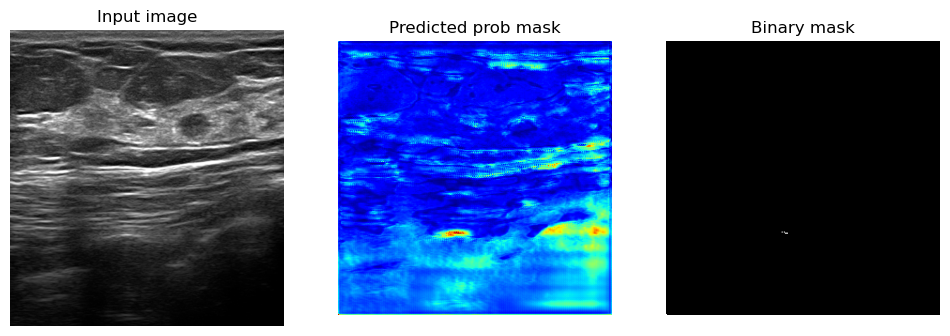

In [24]:
import matplotlib.pyplot as plt

test_image_path = "../data/mass_data/BrEaST-Lesions_USG-images_and_masks/images/case084.png"
#data\mass_data\BrEaST-Lesions_USG-images_and_masks\images

prob_mask, bin_mask = predict_mask(model, test_image_path, threshold=0.1)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input image")
plt.imshow(read_as_grayscale(test_image_path), cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted prob mask")
plt.imshow(prob_mask.numpy(), cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Binary mask")
plt.imshow(bin_mask.numpy(), cmap="gray")
plt.axis("off")

plt.show()


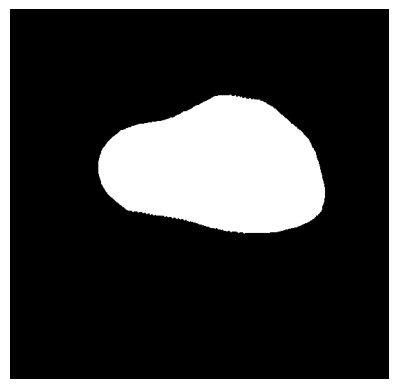

In [18]:
mk = read_as_grayscale("../data/mass_data/BrEaST-Lesions_USG-images_and_masks/labels/case014_tumor.png")
imdisp(mk)

In [30]:
def testerror(x):
    if x < 10:
        raise AttributeError("wrong")

In [31]:
testerror(5)

AttributeError: wrong